# 卷积神经网络实现
Author: Wei Jiangnan 2024.9

--------------------------------------------------------------------------------------------------------------------------
本作业中，使用PyTorch实现一个卷积神经网络，用于在 MNIST 数据集上实现手写数字分类。

--------------------------------------------------------------------------------------------------------------------------


In [8]:
import numpy as np
import torch
import torch.nn as nn

In [9]:
#### 准备数据集
#### 你的环境中应该有torchvision或pickle

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import importlib

# python > 3.4
if importlib.util.find_spec('torchvision') is None: # if you do not have torchvision, use TA's downloaded data
    import pickle as pkl

    with open('./MNIST_dataset_local','rb') as read_file:
        data = pkl.load(read_file)
        read_file.close()

    train_images, train_labels = data['train']
    test_images, test_labels = data['test']

    val_images, val_labels = train_images[5500:], train_labels[5500:]
    train_images, train_labels = train_images[:5500], train_labels[:5500]

    class myMnistDataSet(Dataset):

        def __init__(self,images,labels):
            self.X = images[:,None,...]# add channel dimension
            self.y = labels

        def __len__(self):
            return len(self.X)

        def __getitem__(self, index):
            image = self.X[index]
            label = self.y[index]
            return torch.Tensor(image), torch.tensor(label)[0]
        
    mnist_train = myMnistDataSet(train_images, train_labels.astype('int64'))
    mnist_test = myMnistDataSet(test_images, test_labels.astype('int64'))
    mnist_val = myMnistDataSet(val_images, val_labels.astype('int64'))

else: # use torchvision
    from torchvision import transforms, datasets

    mnist_download_path = './MNIST_dataset'
    datasets.MNIST(root=mnist_download_path, download=True)

    mnist_train = datasets.MNIST(root = mnist_download_path, train = True, transform=transforms.ToTensor())
    mnist_val   = Subset(mnist_train, list(range(5500,6000)))
    mnist_train = Subset(mnist_train, list(range(5500)))

    mnist_test  = datasets.MNIST(root = mnist_download_path, train = False, transform=transforms.ToTensor())


def get_loaders(batch_size):
    train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
    val_loader   = DataLoader(mnist_val, batch_size = batch_size, shuffle=False)
    test_loader  = DataLoader(mnist_test, batch_size = batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# get to know your loader
batch_size = 32
train_loader, val_loader, test_loader = get_loaders(batch_size)

for im, l in val_loader:
    break

print(im.shape, l.shape)
print(l)

torch.Size([32, 1, 28, 28]) torch.Size([32])
tensor([1, 9, 0, 9, 7, 0, 5, 1, 2, 2, 3, 3, 0, 4, 0, 5, 1, 6, 9, 7, 1, 8, 9, 9,
        6, 0, 5, 1, 2, 2, 1, 3])


In [10]:
len(mnist_train)

5500

### 1. CNN （100）

`从零构建你的CNN` 选择任意的损失函数和优化器，训练你的CNN，使其获得最好的测试集准确率。


**`需要的输出`**: 
1. 输出你的CNN的结构，包括每一层的参数数量。（15）
2. 输出你的CNN的训练过程中，每一步（epoch）的训练集（验证集）损失。（15）
3. 训练结束后，画出训练集和验证集的损失随epoch变化的曲线。（15）
4. 在测试集上，测试你得到的最好的模型，输出测试集上的loss和准确率。（15）
5. 输出测试集上的混淆矩阵。（15）
6. 将最好的模型保存下来。（15）
+ **下面的尝试只需选择从四项中任选`一项`进行尝试即可**（10）: 
1. 尝试使用不同的优化器。
2. 尝试使用不同的损失函数。
3. 尝试使用不同的激活函数。
4. 尝试使用不同的正则化技术。

`只有当测试集上的准确率大于97.00%时，才能获得分数。`

[提示]:
1. 如果使用BatchNorm或Dropout，需要注意在训练和测试时的不同。（需要添加两行代码来管理训练和测试）。
2. sklearn的metrics库中有混淆矩阵的函数confusion_matrix。


------------------------------------------------------------------------------------------------------------------------------------------------
`计算消耗`: 
如果你的电脑上有NVIDIA显卡，你可以使用`cuda`来加速计算。但是从理论上来说，`两层CNN`足够使得测试准确率至少为97%。
如果你的电脑CPU不比英特尔酷睿i5-8250U处理器差，并且你的代码实现正确，那么即使没有NVIDIA显卡，程序应该运行得很快。

`鼓励构建不太复杂的CNN`以节省计算成本，因为MNIST是一个相对简单的问题。不过，`只要你的代码能够达到目标，即使CNN很大也没有问题`。

------------------------------------------------------------------------------------------------------------------------------------------------


In [11]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Build CNN

In [12]:
import torch.nn.functional as F # 用于激活函数
# from torch.utils.data import DataLoader, Dataset, Subset # 用于数据加载
from sklearn.metrics import confusion_matrix # 用于计算混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns # 用于画混淆矩阵

# 定义 CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # 调用父类的构造函数
        # 这一部分来于定义网络结构
        # 因为图片是灰度图，只有一个通道，所以输入通道数为1。输出通道数为32，卷积核大小为3，步长为1，padding为1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) 
       
        # BatchNorm2d用于批标准化
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # 全连接层
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5) # Dropout层，防止过拟合，随机丢弃一些神经元

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) # 卷积层，激活函数是ReLU
        x = F.max_pool2d(x, kernel_size=2) # 池化层，就是取一个区域的最大值, kernel_size=2表示取2*2的区域
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(x.size(0), -1)  # 拉平
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 初始化模型
model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Parameters of CNN

In [13]:
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Train CNN

In [14]:
# 优化器和损失函数
lr = 1e-3
num_epochs = 20
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# 用于存储最好的模型
best_model_weights=None
best_val_loss=float('inf')
# 训练和验证
def train_model(model,train_loader,val_loader,criterion,optimizer,num_epochs,best_model_weights,best_val_loss):
    train_losses=[]
    val_losses=[]
    
    for epoch in range(num_epochs):
        model.train()
        train_loss=0
        for images,labels in train_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            train_loss+=loss.item()*images.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss/=len(mnist_train)
        train_losses.append(train_loss)
        model.eval()
        val_loss=0
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels=images.to(device),labels.to(device)
                outputs=model(images)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()*images.size(0)
        val_loss/=len(mnist_val)
        val_losses.append(val_loss)
        if val_loss<best_val_loss:
            best_val_loss=val_loss
            best_model_weights=model.state_dict()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    torch.save(best_model_weights, 'best_cnn.pth')
    return train_losses,val_losses

train_losses,val_losses = train_model(model,train_loader,val_loader,criterion,optimizer,num_epochs,best_model_weights,best_val_loss)
'''
#示例代码，建议自行实现以达到更好的理解
lr=1e-4
num_epoch=20
CEloss=F.cross_entropy
optmi=torch.optim.Adam(res_model.parameters(),lr=lr)
best_cnn_pt=None
train_losses, val_losses = [], []
#train
for epoch in range(num_epoch):
    train_loss=0
    for im,l in train_loader:
        model.train()
        im=im.to(device)
        l=l.to(device)
        pred=res_model(im)
        loss=CEloss(pred,l)
        train_loss+=loss.item()*len(l)
        optmi.zero_grad()
        loss.backward()
        optmi.step()
    train_loss/=len(mnist_train)
    val_loss=0
    #val
    with torch.no_grad():
        model.eval()
        for im,l in val_loader:
            im=im.to(device)
            l=l.to(device)
            pred=res_model(im)
            loss=CEloss(pred,l)
            val_loss+=loss.item()*len(l)
    val_loss/=len(mnist_val)
    train_losses.append(train_loss)
    if epoch==0 or val_loss<min(val_losses):
        best_cnn_pt=res_model.state_dict()
    val_losses.append(val_loss)
    print('epoch: %d, train_loss: %f, val_loss: %f'%(epoch+1,train_loss,val_loss))
#save
torch.save(best_cnn_pt,'best_cnn.pt')
'''

Epoch [1/20], Train Loss: 0.6576, Val Loss: 0.1565
Epoch [2/20], Train Loss: 0.2424, Val Loss: 0.1132
Epoch [3/20], Train Loss: 0.1796, Val Loss: 0.1082
Epoch [4/20], Train Loss: 0.1455, Val Loss: 0.0990
Epoch [5/20], Train Loss: 0.1306, Val Loss: 0.0794
Epoch [6/20], Train Loss: 0.1031, Val Loss: 0.0841
Epoch [7/20], Train Loss: 0.1004, Val Loss: 0.0889
Epoch [8/20], Train Loss: 0.0970, Val Loss: 0.0940
Epoch [9/20], Train Loss: 0.0821, Val Loss: 0.0751
Epoch [10/20], Train Loss: 0.0746, Val Loss: 0.0841
Epoch [11/20], Train Loss: 0.0602, Val Loss: 0.0827
Epoch [12/20], Train Loss: 0.0659, Val Loss: 0.0854
Epoch [13/20], Train Loss: 0.0550, Val Loss: 0.0722
Epoch [14/20], Train Loss: 0.0585, Val Loss: 0.1139
Epoch [15/20], Train Loss: 0.0583, Val Loss: 0.0817
Epoch [16/20], Train Loss: 0.0554, Val Loss: 0.0812
Epoch [17/20], Train Loss: 0.0557, Val Loss: 0.0877
Epoch [18/20], Train Loss: 0.0388, Val Loss: 0.0834
Epoch [19/20], Train Loss: 0.0430, Val Loss: 0.0871
Epoch [20/20], Train 

"\n#示例代码，建议自行实现以达到更好的理解\nlr=1e-4\nnum_epoch=20\nCEloss=F.cross_entropy\noptmi=torch.optim.Adam(res_model.parameters(),lr=lr)\nbest_cnn_pt=None\ntrain_losses, val_losses = [], []\n#train\nfor epoch in range(num_epoch):\n    train_loss=0\n    for im,l in train_loader:\n        model.train()\n        im=im.to(device)\n        l=l.to(device)\n        pred=res_model(im)\n        loss=CEloss(pred,l)\n        train_loss+=loss.item()*len(l)\n        optmi.zero_grad()\n        loss.backward()\n        optmi.step()\n    train_loss/=len(mnist_train)\n    val_loss=0\n    #val\n    with torch.no_grad():\n        model.eval()\n        for im,l in val_loader:\n            im=im.to(device)\n            l=l.to(device)\n            pred=res_model(im)\n            loss=CEloss(pred,l)\n            val_loss+=loss.item()*len(l)\n    val_loss/=len(mnist_val)\n    train_losses.append(train_loss)\n    if epoch==0 or val_loss<min(val_losses):\n        best_cnn_pt=res_model.state_dict()\n    val_losses.append(va

### Test CNN

In [15]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    test_loss /= total
    test_accuracy = correct / total * 100
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return all_labels, all_preds
all_labels, all_preds = test_model(model, test_loader, criterion)
'''
#示例代码，建议自行实现以达到更好的理解
test_loss,test_acc,test_num=0,0,0
res_model.load_state_dict(best_cnn_pt)
res_model=res_model.to(device)
total_label=[]
total_pred=[]
with torch.no_grad():
    for im,l in test_loader:
        model.eval()
        im=im.to(device)
        l=l.to(device)
        pred=res_model(im)
        test_loss+=CEloss(pred,l)*len(l)
        pred=torch.argmax(pred,dim=-1)
        acc=(pred==l).float().sum().cpu()
        test_acc+=acc
        test_num+=len(l)
        total_label.append(l.cpu().numpy())
        total_pred.append(pred.cpu().numpy())
test_loss/=test_num
test_acc/=test_num
print('test_loss: %f, test_acc: %.2f%%'%(test_loss,test_acc*100))
'''

Test Loss: 0.0678, Test Accuracy: 98.18%


"\n#示例代码，建议自行实现以达到更好的理解\ntest_loss,test_acc,test_num=0,0,0\nres_model.load_state_dict(best_cnn_pt)\nres_model=res_model.to(device)\ntotal_label=[]\ntotal_pred=[]\nwith torch.no_grad():\n    for im,l in test_loader:\n        model.eval()\n        im=im.to(device)\n        l=l.to(device)\n        pred=res_model(im)\n        test_loss+=CEloss(pred,l)*len(l)\n        pred=torch.argmax(pred,dim=-1)\n        acc=(pred==l).float().sum().cpu()\n        test_acc+=acc\n        test_num+=len(l)\n        total_label.append(l.cpu().numpy())\n        total_pred.append(pred.cpu().numpy())\ntest_loss/=test_num\ntest_acc/=test_num\nprint('test_loss: %f, test_acc: %.2f%%'%(test_loss,test_acc*100))\n"

### Plot loss

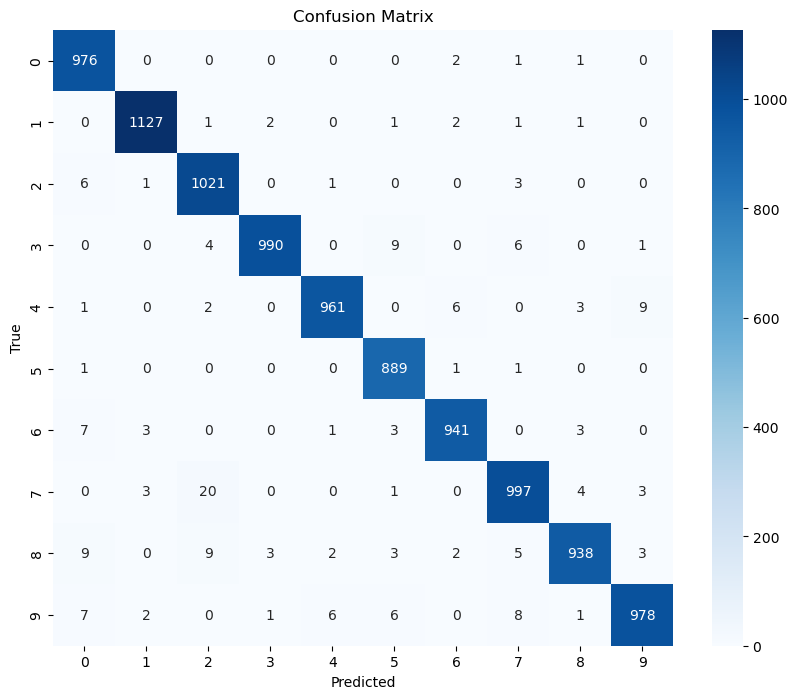

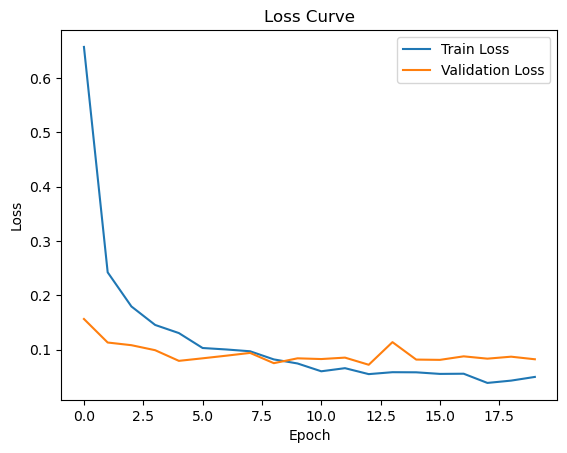

In [16]:
# 混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 画出训练损失和验证损失曲线
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

### Other Optimizer

Epoch [1/20], Train Loss: 1.9837, Val Loss: 1.6456
Epoch [2/20], Train Loss: 1.4357, Val Loss: 1.1410
Epoch [3/20], Train Loss: 1.0638, Val Loss: 0.8373
Epoch [4/20], Train Loss: 0.8289, Val Loss: 0.6491
Epoch [5/20], Train Loss: 0.6841, Val Loss: 0.5331
Epoch [6/20], Train Loss: 0.5930, Val Loss: 0.4547
Epoch [7/20], Train Loss: 0.5259, Val Loss: 0.4022
Epoch [8/20], Train Loss: 0.4644, Val Loss: 0.3645
Epoch [9/20], Train Loss: 0.4270, Val Loss: 0.3310
Epoch [10/20], Train Loss: 0.3996, Val Loss: 0.3027
Epoch [11/20], Train Loss: 0.3654, Val Loss: 0.2824
Epoch [12/20], Train Loss: 0.3398, Val Loss: 0.2642
Epoch [13/20], Train Loss: 0.3217, Val Loss: 0.2533
Epoch [14/20], Train Loss: 0.3072, Val Loss: 0.2389
Epoch [15/20], Train Loss: 0.2926, Val Loss: 0.2267
Epoch [16/20], Train Loss: 0.2811, Val Loss: 0.2195
Epoch [17/20], Train Loss: 0.2681, Val Loss: 0.2106
Epoch [18/20], Train Loss: 0.2569, Val Loss: 0.2019
Epoch [19/20], Train Loss: 0.2422, Val Loss: 0.1964
Epoch [20/20], Train 

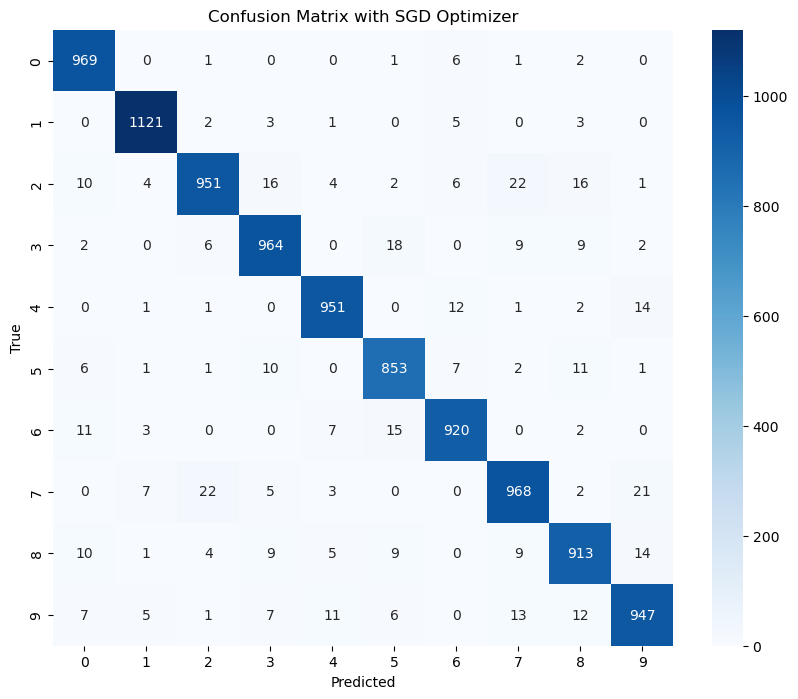

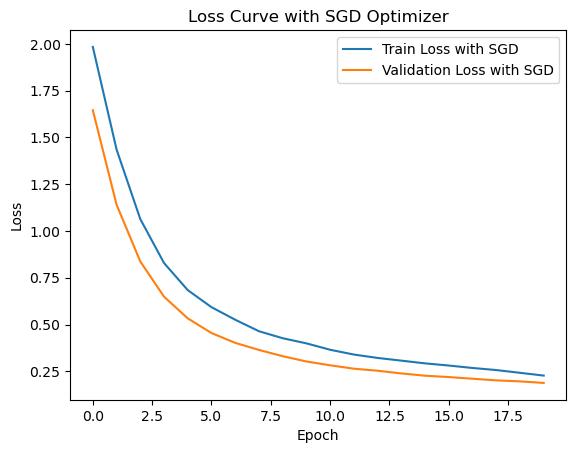

In [17]:
model_sgd = SimpleCNN().to(device)
# 优化器和损失函数
lr_sgd = 1e-3
num_epochs_sgd = 20
criterion_sgd = nn.CrossEntropyLoss() # 交叉熵损失函数
sgd_optimizer = torch.optim.SGD(model_sgd.parameters(), lr=lr)

# 训练和验证
train_losses_sgd, val_losses_sgd = train_model(model_sgd, train_loader, val_loader, criterion_sgd, sgd_optimizer, num_epochs_sgd, best_model_weights, best_val_loss)

# 测试模型
all_labels_sgd, all_preds_sgd = test_model(model_sgd, test_loader, criterion_sgd)

# 混淆矩阵
conf_matrix_sgd = confusion_matrix(all_labels_sgd, all_preds_sgd)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_sgd, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.title("Confusion Matrix with SGD Optimizer")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 画出训练损失和验证损失曲线
plt.plot(train_losses_sgd, label="Train Loss with SGD")
plt.plot(val_losses_sgd, label="Validation Loss with SGD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve with SGD Optimizer")
plt.show()

### Other Loss Function

### Other activation function

### Other Regularization

# 实验收获与感悟
+ 学习内容——CNN
    + 构建一个卷积神经网络主要需要考虑的内容：卷积核，步长，padding，池化
    + 选择合适的激活函数，如ReLU、Sigmoid等
    + 使用Dropout等正则化技术来防止过拟合
    + 选择合适的损失函数和优化器，如交叉熵损失函数和Adam优化器
    + 设计合适的网络结构，包括卷积层、池化层和全连接层的数量和顺序